In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Cài đặt các thư viện cần thiết
print(" Đang cài đặt thư viện 'pyarrow' và 'wordcloud'...")
!pip install pyarrow wordcloud -q
print(" Cài đặt thành công!")

# Import các thư viện
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from wordcloud import WordCloud
import numpy as np

# Tải và đọc dữ liệu từ file Parquet
file_path = '/content/drive/MyDrive/SIC_PROJECT/Data/Processed/cleaned_games_raw.parquet'
try:
    df = pd.read_parquet(file_path)
    print("\nĐọc file thành công!")
except FileNotFoundError:
    print("\nLỗi: Không tìm thấy file")
    df = pd.DataFrame()

# Chuẩn bị dữ liệu chung
if not df.empty:
    df['release_year'] = pd.to_datetime(df['released'], errors='coerce').dt.year

    df_genres_exploded = df.explode('genres').dropna(subset=['genres'])
    df_platforms_exploded = df.explode('platforms').dropna(subset=['platforms'])
    df_tags_exploded = df.explode('tags').dropna(subset=['tags'])

    print(" Dữ liệu đã được chuẩn bị xong và sẵn sàng cho phân tích.")

# Font
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False


 Đang cài đặt thư viện 'pyarrow' và 'wordcloud'...
 Cài đặt thành công!

Đọc file thành công!
 Dữ liệu đã được chuẩn bị xong và sẵn sàng cho phân tích.


###1. Tổng quan dữ liệu

 1.1. Vẽ biểu đồ số lượng game phát hành qua các năm


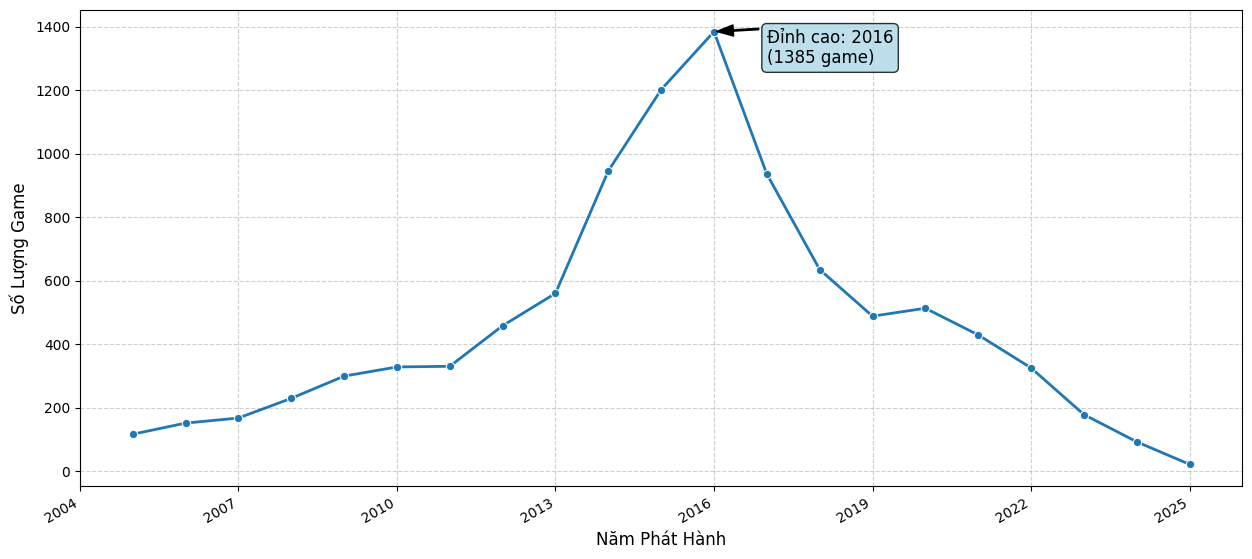

In [4]:
print(" 1.1. Vẽ biểu đồ số lượng game phát hành qua các năm")
if not df.empty:
    games_per_year = df['release_year'].value_counts().sort_index()
    games_per_year = games_per_year.loc[2000:df['release_year'].max()]

    plt.figure(figsize=(15, 7))
    ax = sns.lineplot(x=games_per_year.index, y=games_per_year.values, marker='o', lw=2)
    ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    plt.gcf().autofmt_xdate()

    peak_year = games_per_year.idxmax()
    peak_value = games_per_year.max()

    ax.annotate(f'Đỉnh cao: {int(peak_year)}\n({int(peak_value)} game)',
                xy=(peak_year, peak_value),
                xytext=(peak_year + 1, peak_value -100),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
                fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="lightblue", ec="k", lw=1, alpha=0.8))

    plt.xlabel('Năm Phát Hành', fontsize=12)
    plt.ylabel('Số Lượng Game', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


Biểu đồ này phác họa rõ nét một chu kỳ hoàn chỉnh của ngành công nghiệp game trong hai thập kỷ qua, có thể tóm tắt như sau:


*   Giai đoạn Tăng trưởng (2004-2016):
    
    -Phát hiện: Số lượng game tăng trưởng một cách bùng nổ, đạt đỉnh vào năm 2016 với 1385 tựa game.

    -Lý giải: Giai đoạn này được thúc đẩy mạnh mẽ bởi sự trỗi dậy của các nhà phát triển độc lập (indie) nhờ các nền tảng phân phối kỹ thuật số như Steam và các công cụ làm game (Unity, Unreal) ngày càng dễ tiếp cận.

*   Giai đoạn Suy giảm & Tái cấu trúc (sau 2016):

    -Phát hiện: Ngay sau khi đạt đỉnh, thị trường bắt đầu xu hướng đi xuống một cách rõ rệt và ổn định.

    -Lý giải: Nguyên nhân chính là sự chuyển dịch của các nhà phát hành lớn sang mô hình "Game như một Dịch vụ" (GaaS), tập trung vào một vài game bom tấn và cập nhật liên tục. Cùng với đó, chi phí sản xuất tăng cao và sự bão hòa chung của thị trường cũng là những yếu tố quan trọng.

=> Kết luận tổng quan: Biểu đồ thể hiện sự thay đổi chiến lược của ngành game, từ việc tập trung vào số lượng sang việc đầu tư vào chất lượng và duy trì các tựa game dịch vụ lâu dài.

Loại biểu đồ sử dụng: Biểu đồ đường(Line Chart)

Lý do lựa chọn: Biểu đồ đường là công cụ tối ưu để thể hiện sự thay đổi liên tục của một biến số theo thời gian, giúp dễ dàng xác định xu hướng (trend) và các điểm biến động quan trọng (peaks, troughs).



1.2. Vẽ biểu đồ cột cho tỷ lệ dữ liệu bị thiếu


/tmp/ipython-input-5-429446730.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=missing_percent.index, y=missing_percent.values, palette='Reds_r')


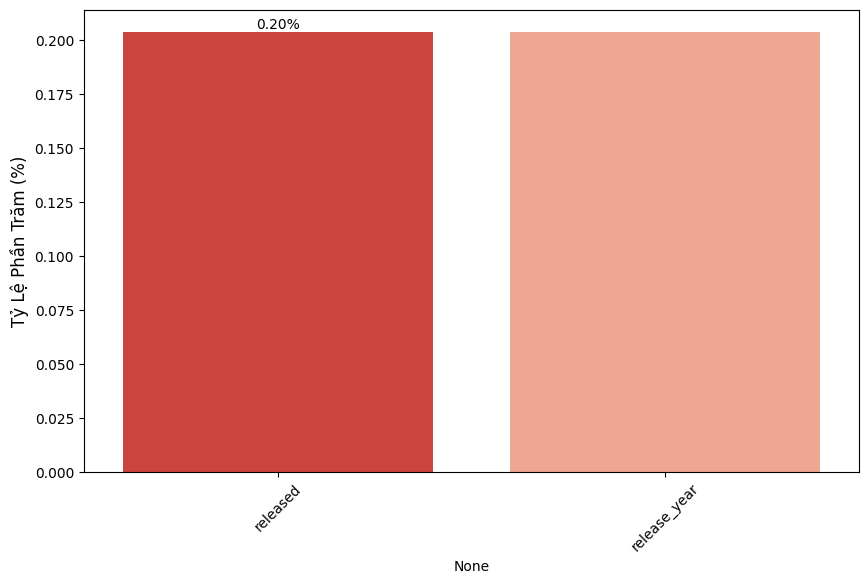

In [5]:
# --- 1.2. Tỷ lệ thiếu dữ liệu---
print("\n1.2. Vẽ biểu đồ cột cho tỷ lệ dữ liệu bị thiếu")
if not df.empty:
    missing_data = df.isnull().sum()
    missing_percent = (missing_data[missing_data > 0] / len(df)) * 100

    if not missing_percent.empty:
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(x=missing_percent.index, y=missing_percent.values, palette='Reds_r')
        ax.bar_label(ax.containers[0], fmt='%.2f%%')
        plt.ylabel('Tỷ Lệ Phần Trăm (%)', fontsize=12)
        plt.xticks(rotation=45)
        plt.show()
    else:
        print("Không có dữ liệu nào bị thiếu trong tập dữ liệu.")


Biểu đồ này trực quan hóa tình trạng thiếu hụt dữ liệu, một bước thiết yếu trong quy trình Đánh giá Chất lượng Dữ liệu (Data Quality Assessment).

*   Phân tích trực quan: Tập dữ liệu thể hiện mức độ hoàn thiện rất cao. Chỉ có hai cột liên quan đến ngày phát hành là released và release_year ghi nhận sự thiếu hụt dữ liệu.

*   Định lượng cụ thể: Tỷ lệ thiếu dữ liệu ở cả hai cột này là cực kỳ thấp, chỉ 0.20%. Điều này đồng nghĩa với việc 99.8% các bản ghi trong dataset đều có đầy đủ thông tin về ngày phát hành.

*   Ý nghĩa và Chiến lược xử lý: Trong bối cảnh Big Data, tỷ lệ thiếu 0.20% là không đáng kể, cho thấy giai đoạn Tiền xử lý đã được thực hiện rất tốt. Với một tỷ lệ thấp như vậy, chiến lược xử lý đơn giản và hiệu quả nhất là loại bỏ các hàng chứa giá trị thiếu. Phương pháp này sẽ không làm suy giảm sức mạnh thống kê hay gây ra sai lệch cho các mô hình phân tích sau này. Do đó, chúng ta có thể bỏ qua các kỹ thuật điền dữ liệu phức tạp, giúp đơn giản hóa pipeline phân tích và tập trung nguồn lực vào các giai đoạn quan trọng hơn như Feature Engineering và xây dựng mô hình.

=> Kết luận: Tóm lại, bộ dữ liệu đã đạt yêu cầu về độ hoàn chỉnh, cho phép chúng ta tự tin chuyển sang các giai đoạn phân tích sâu hơn mà không cần các bước xử lý dữ liệu thiếu phức tạp.

Loại biểu đồ sử dụng: Biểu đồ cột (Bar Chart).

Lý do lựa chọn: Trong trường hợp chỉ có một vài cột chứa dữ liệu thiếu, Biểu đồ cột là công cụ trực quan hóa hiệu quả và chính xác hơn so với Heatmap.

###2. Thể loại game (Genres)

2.1. Vẽ biểu đồ Top 10 thể loại game phổ biến


/tmp/ipython-input-6-3277949921.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_10_genres.values, y=top_10_genres.index, palette='viridis')


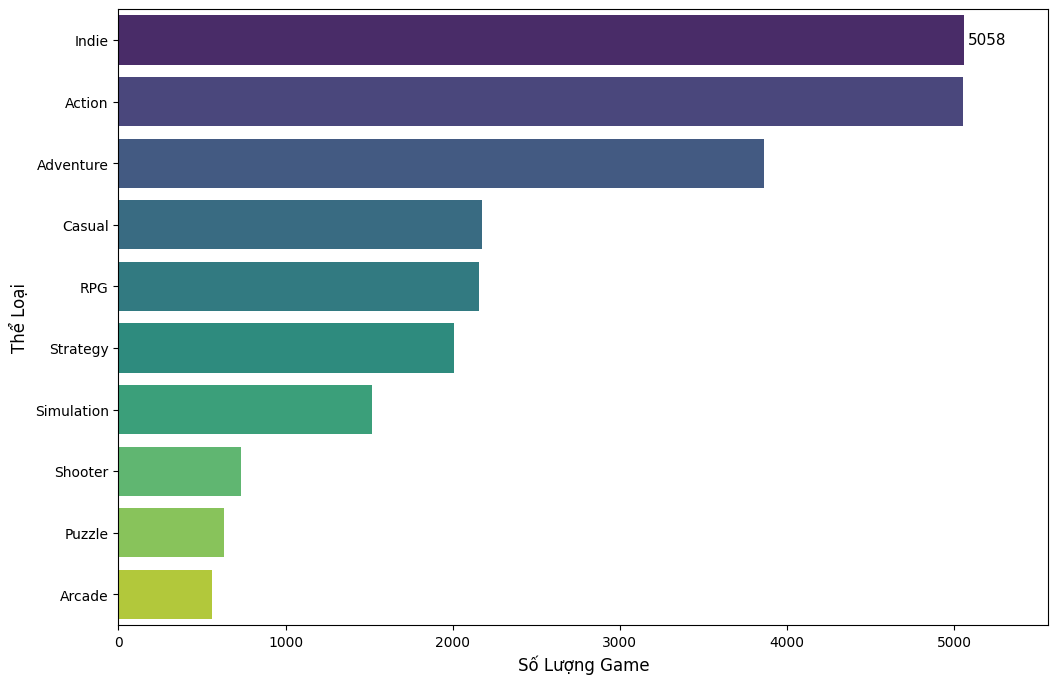

In [6]:
print("2.1. Vẽ biểu đồ Top 10 thể loại game phổ biến")
if 'df_genres_exploded' in locals():
    plt.figure(figsize=(12, 8))
    top_10_genres = df_genres_exploded['genres'].value_counts().nlargest(10)

    ax = sns.barplot(x=top_10_genres.values, y=top_10_genres.index, palette='viridis')
    ax.bar_label(ax.containers[0], fmt='%.0f', padding=3, fontsize=11)


    plt.xlabel('Số Lượng Game', fontsize=12)
    plt.ylabel('Thể Loại', fontsize=12)
    plt.xlim(0, top_10_genres.values.max() * 1.1)
    plt.show()


Biểu đồ này cho thấy sự phân bổ về số lượng game trong các thể loại phổ biến nhất, từ đó phản ánh xu hướng sản xuất và thị hiếu của thị trường.

*  Sự thống trị của Indie và Action:

    -Phát hiện: Indie (Game độc lập) và Action (Hành động) là hai thể loại vượt trội và có số lượng gần như tương đương nhau, với hơn 5000 tựa game mỗi loại. Adventure (Phiêu lưu) theo sát ở vị trí thứ ba.

    -Ý nghĩa: Điều này cho thấy hai xu hướng chính đang diễn ra song song. Một mặt, các game Hành động và Phiêu lưu vẫn là những "trụ cột" cốt lõi, thu hút phần lớn các nhà sản xuất và người chơi. Mặt khác, sự trỗi dậy mạnh mẽ của game Indie cho thấy sự dân chủ hóa của ngành công nghiệp game, nơi các nhà phát triển nhỏ lẻ có thể tự do sáng tạo và đóng góp một số lượng khổng lồ các sản phẩm đa dạng ra thị trường.

*   Phân Cấp Rõ Rệt:

    -Phát hiện: Có một khoảng cách đáng kể giữa top 3 (Indie, Action, Adventure) và phần còn lại của danh sách. Nhóm giữa bao gồm Casual, RPG, Strategy, và Simulation với số lượng game dao động quanh mức 2000. Nhóm cuối cùng (Shooter, Puzzle, Arcade) có số lượng thấp hơn hẳn.

    -Ý nghĩa: Sự phân cấp này cho thấy thị trường có sự tập trung rõ ràng. Trong khi các thể loại ở top đầu có sức hấp dẫn đại chúng, các thể loại ở nhóm giữa và cuối phục vụ cho các nhóm người chơi chuyên biệt hơn (niche market) với sở thích riêng. Đáng chú ý, Shooter (Bắn súng), dù có nhiều "bom tấn" nổi tiếng, lại có tổng số lượng game phát hành ít hơn so với các thể loại khác như Strategy hay RPG.

=> Kết luận tổng quan: Thị trường game hiện tại được định hình bởi sức mạnh của các thể loại kinh điển như Hành động/Phiêu lưu và sự bùng nổ sáng tạo từ cộng đồng game Indie. Sự đa dạng của các thể loại khác cho thấy một thị trường ngách phong phú, đáp ứng nhiều thị hiếu khác nhau của người chơi.

Loại biểu đồ sử dụng: Biểu đồ cột ngang (Horizontal Bar Chart).

Lý do lựa chọn: So sánh hiệu quả, dễ đọc, Sắp xếp có chủ đích, tăng cường thông tin


 2.2. Vẽ biểu đồ phân phối Rating theo thể loại


/tmp/ipython-input-7-3058999252.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_top_genres, x='rating', y='genres', palette='pastel', order=top_10_genre_names,


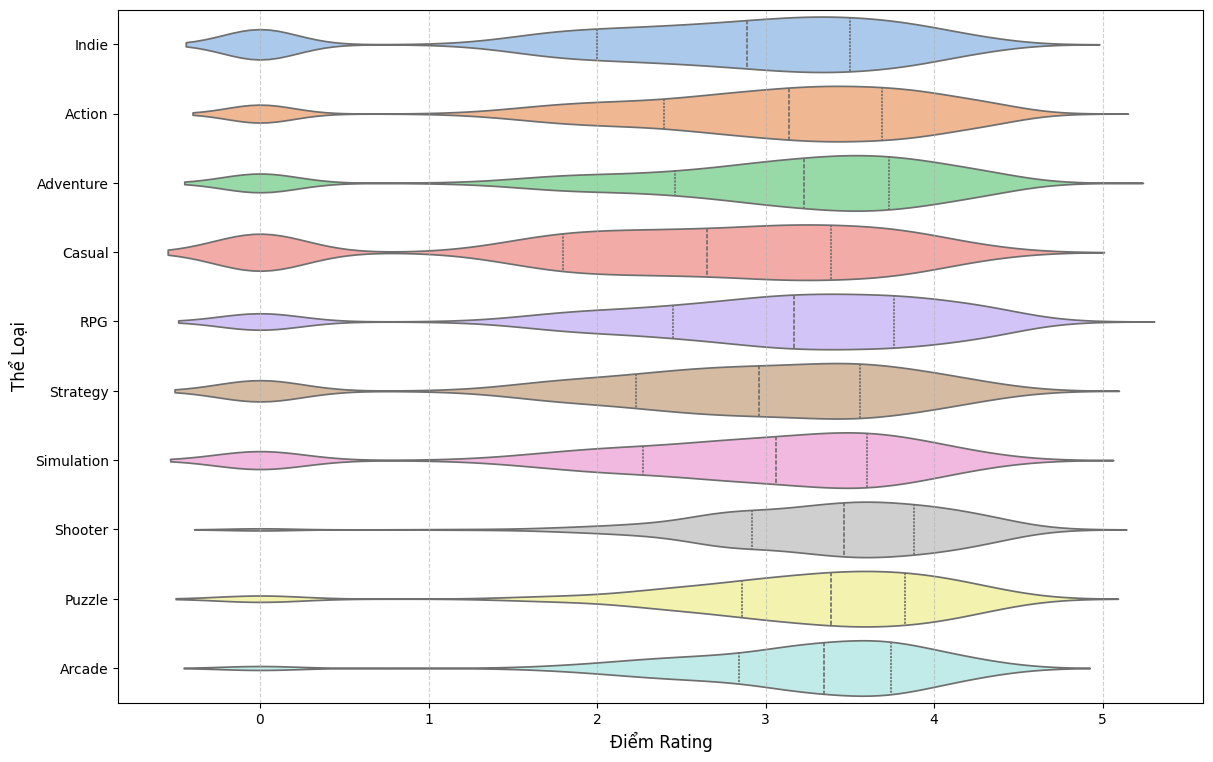

In [7]:
print("\n 2.2. Vẽ biểu đồ phân phối Rating theo thể loại")
if 'df_genres_exploded' in locals():
    top_10_genre_names = df_genres_exploded['genres'].value_counts().nlargest(10).index
    df_top_genres = df_genres_exploded[df_genres_exploded['genres'].isin(top_10_genre_names)]

    plt.figure(figsize=(14, 9))
    sns.violinplot(data=df_top_genres, x='rating', y='genres', palette='pastel', order=top_10_genre_names,
                   inner='quartile')


    plt.xlabel('Điểm Rating', fontsize=12)
    plt.ylabel('Thể Loại', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()


Biểu đồ này cho phép chúng ta kiểm tra phân phối xác suất của biến liên tục (rating) trên các danh mục khác nhau của biến phân loại (genres).


*   Phân phối một đỉnh, lệch trái:

    -Phát hiện: Đối với hầu hết các thể loại chính như Action, Adventure, Shooter, và RPG, phân phối có dạng một đỉnh (unimodal), với mật độ tập trung cao nhất (phần thân violin rộng nhất) trong khoảng từ 3.0 đến 4.5. Đuôi của phân phối kéo dài về phía bên trái (điểm thấp), cho thấy một độ lệch trái (negative skew).

    -Ý nghĩa: Điều này chỉ ra rằng, đối với các thể loại này, phần lớn dữ liệu hội tụ quanh một giá trị trung tâm (central tendency) ở mức "khá/tốt". Sự tồn tại của đuôi bên trái cho thấy sự hiện diện của các giá trị ngoại lai (outliers) ở mức điểm thấp, nhưng chúng không chiếm số lượng lớn.

*   Phân phối đa phương thức và Phương sai cao:
    
    -Phát hiện: Các thể loại Indie, RPG, và Casual thể hiện một hình dạng phân phối phức tạp hơn. Đặc biệt, Indie cho thấy dấu hiệu của một phân phối đa phương thức (multimodal), với một đỉnh chính ở khoảng 3.5-4.0 và một đỉnh phụ ở mức điểm gần 0.

    -Ý nghĩa: Sự tồn tại của nhiều đỉnh cho thấy có các quần thể con (sub-populations) riêng biệt bên trong dữ liệu. Trong trường hợp của Indie, có thể có một quần thể là các game indie chất lượng cao được cộng đồng đón nhận, và một quần thể khác là các game chất lượng rất thấp. Điều này dẫn đến phương sai (variance) của điểm rating trong các thể loại này rất cao, làm cho việc dự đoán trở nên thách thức hơn.

*   Sự khác biệt về Độ lệch:

    -Phát hiện: Phân phối của Puzzle và Shooter có xu hướng lệch về phía bên phải (phần thân violin dày đặc ở vùng điểm cao) nhiều hơn so với các thể loại khác.

    -Ý nghĩa: Điều này cho thấy một tỷ lệ lớn hơn các game trong hai thể loại này nhận được điểm đánh giá cao từ người dùng. Đây có thể là một tín hiệu (signal) quan trọng nếu chúng ta xây dựng một mô hình dự đoán rating.

=> Kết luận cho Feature Engineering: Sự khác biệt rõ rệt về hình dạng phân phối, độ lệch, và phương sai của biến rating khi được phân nhóm theo genres cho thấy genres là một biến đặc trưng (feature) có sức mạnh dự báo cao.

Loại biểu đồ: Biểu đồ Violin (Violin Plot).

Lý do lựa chọn: So với Box Plot, Violin Plot cung cấp một cái nhìn toàn diện hơn về cấu trúc của dữ liệu. Nó không chỉ tóm tắt các thống kê cơ bản mà còn trực quan hóa toàn bộ phân phối xác suất, giúp phát hiện các đặc điểm phức tạp như tính đa phương thức (multimodality).


###3. Nền tảng (Platforms)

3.1. Vẽ biểu đồ Top 10 nền tảng có nhiều game nhất


/tmp/ipython-input-8-2742332682.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_10_platforms.values, y=top_10_platforms.index, palette='mako')


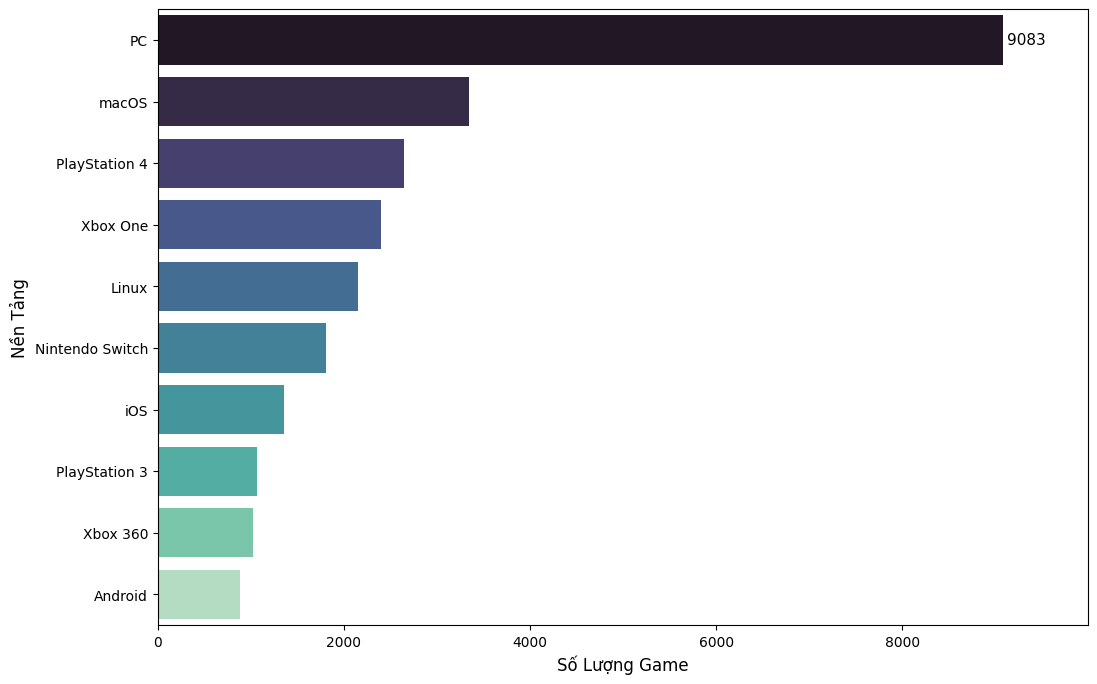

In [8]:
print("3.1. Vẽ biểu đồ Top 10 nền tảng có nhiều game nhất")
if 'df_platforms_exploded' in locals():
    plt.figure(figsize=(12, 8))
    top_10_platforms = df_platforms_exploded['platforms'].value_counts().nlargest(10)

    ax = sns.barplot(x=top_10_platforms.values, y=top_10_platforms.index, palette='mako')
    ax.bar_label(ax.containers[0], fmt='%.0f', padding=3, fontsize=11)


    plt.xlabel('Số Lượng Game', fontsize=12)
    plt.ylabel('Nền Tảng', fontsize=12)
    plt.xlim(0, top_10_platforms.values.max() * 1.1)
    plt.show()

Biểu đồ cho thấy sự thống trị của các hệ sinh thái nền tảng khác nhau trong ngành game.

*   PC là nền tảng thống trị tuyệt đối: Với số lượng game vượt trội, PC thể hiện
sức mạnh của một hệ sinh thái mở, cho phép bất kỳ ai cũng có thể phát hành game. Tuy nhiên, điều này tạo ra một lớp dữ liệu mất cân bằng (imbalanced class), có thể làm thiên vị các mô hình phân tích nếu không được xử lý cẩn thận.
*   Hệ máy Console vẫn rất mạnh mẽ: Sự hiện diện của PlayStation 4, Xbox One và cả các thế hệ cũ hơn như PS3, Xbox 360 cho thấy thành công của các hệ sinh thái đóng và tầm quan trọng của việc phân tích theo vòng đời sản phẩm.

*   Mobile và các nền tảng khác: iOS và Android có vẻ ít được đại diện trong tập dữ liệu này so với quy mô thực tế của thị trường, cho thấy khả năng có sai lệch trong quá trình thu thập dữ liệu (data collection bias).

=> Kết luận: PC là nền tảng đa dạng và phổ biến nhất, nhưng sức mạnh của các hệ sinh thái console là không thể phủ nhận. Khi phân tích, cần lưu ý đến sự mất cân bằng của dữ liệu và khả năng sai lệch từ nguồn gốc dữ liệu.


3.2. Vẽ biểu đồ phân phối Rating theo nền tảng


/tmp/ipython-input-9-4035049715.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_top_platforms, x='rating', y='platforms', palette='pastel', order=top_10_platform_names,


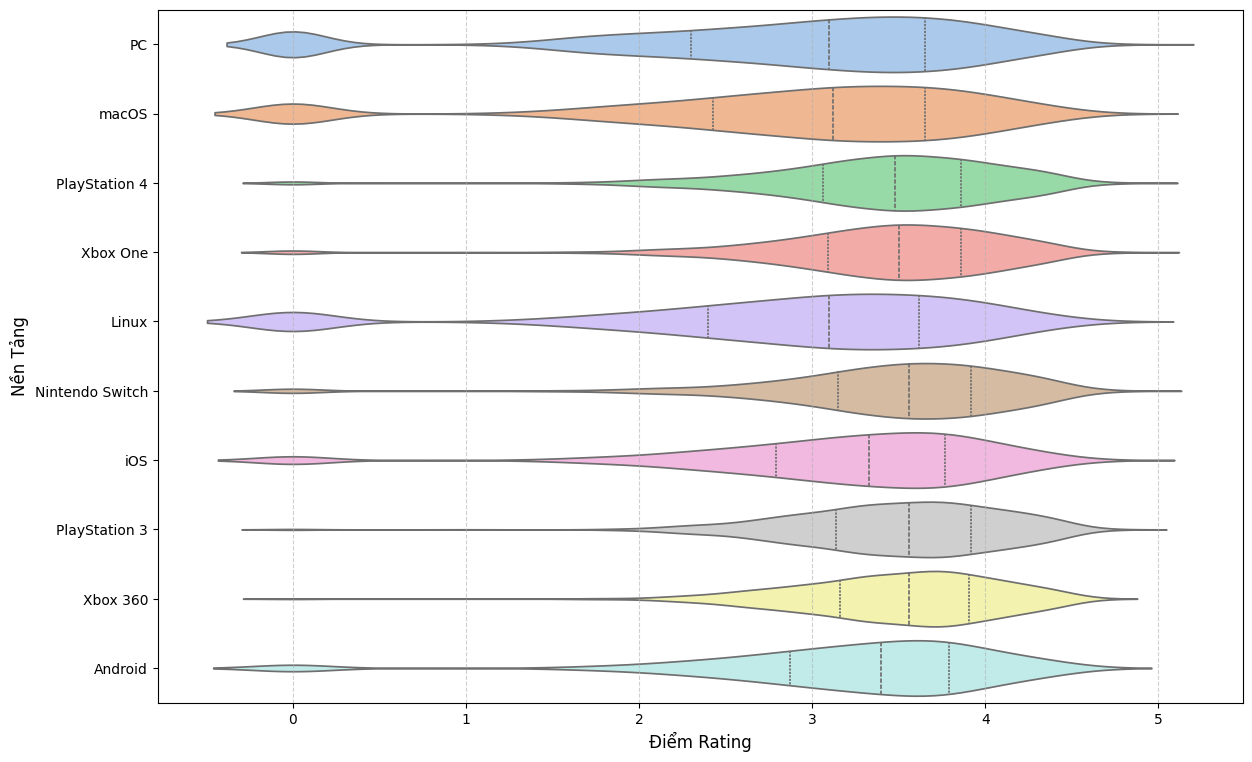

In [9]:
print("\n3.2. Vẽ biểu đồ phân phối Rating theo nền tảng")
if 'df_platforms_exploded' in locals():
    top_10_platform_names = df_platforms_exploded['platforms'].value_counts().nlargest(10).index
    df_top_platforms = df_platforms_exploded[df_platforms_exploded['platforms'].isin(top_10_platform_names)]

    plt.figure(figsize=(14, 9))
    sns.violinplot(data=df_top_platforms, x='rating', y='platforms', palette='pastel', order=top_10_platform_names,
                   inner='quartile')


    plt.xlabel('Điểm Rating', fontsize=12)
    plt.ylabel('Nền Tảng', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()

Biểu đồ này cho thấy sự khác biệt rõ rệt về chất lượng game giữa các hệ sinh thái nền tảng.


*   PC & macOS (Hệ sinh thái Mở): Có sự phân hóa chất lượng cực lớn. Biểu đồ cho thấy có cả những "siêu phẩm" được đánh giá rất cao, đồng thời cũng có một lượng lớn game chất lượng rất thấp. Điều này là do bất kỳ ai cũng có thể phát hành game trên PC.
*   Console (PlayStation & Xbox): Chất lượng game ổn định và đồng đều hơn nhiều. Điểm rating tập trung chủ yếu ở mức "khá/tốt" và không có cụm game bị điểm 0. Điều này là do các nhà sản xuất như Sony và Microsoft có quy trình kiểm duyệt chặt chẽ, giúp lọc bỏ các game chất lượng quá thấp.
*   Mobile & Nintendo Switch: Là sự pha trộn giữa hai mô hình trên, vừa có sự đa dạng của game indie, vừa có sự kiểm soát nhất định.

=> Kết luận: Mô hình kinh doanh của nền tảng (mở hay đóng) ảnh hưởng trực tiếp đến phân phối chất lượng game. Platform là một đặc trưng (feature) rất quan trọng để dự đoán rating của một game.

###4. Đánh giá (Ratings)

4.1. Vẽ biểu đồ phân phối của điểm Rating 


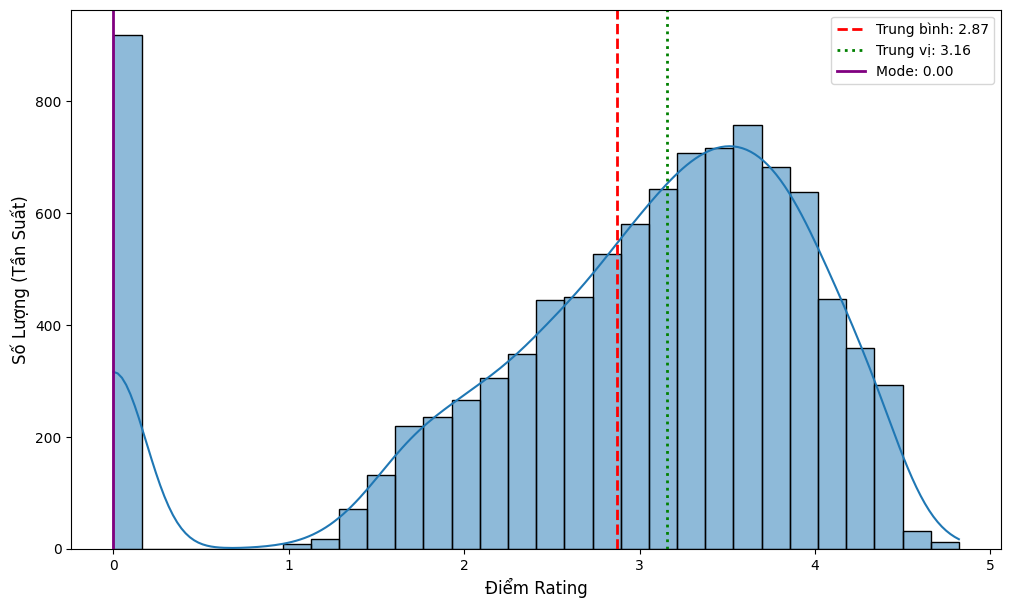

In [10]:
print("4.1. Vẽ biểu đồ phân phối của điểm Rating ")
if not df.empty:
    plt.figure(figsize=(12, 7))
    sns.histplot(df['rating'].dropna(), bins=30, kde=True)

    mean_score = df['rating'].mean()
    median_score = df['rating'].median()
    mode_score = df['rating'].mode()[0]

    plt.axvline(mean_score, color='red', linestyle='--', linewidth=2, label=f'Trung bình: {mean_score:.2f}')
    plt.axvline(median_score, color='green', linestyle=':', linewidth=2, label=f'Trung vị: {median_score:.2f}')
    plt.axvline(mode_score, color='purple', linestyle='-', linewidth=2, label=f'Mode: {mode_score:.2f}')


    plt.xlabel('Điểm Rating', fontsize=12)
    plt.ylabel('Số Lượng (Tần Suất)', fontsize=12)
    plt.legend()
    plt.show()


Biểu đồ này cho thấy một phân phối hai đỉnh (bimodal), chứng tỏ dữ liệu không đồng nhất.

*   Đỉnh thứ nhất ở điểm 0: Được tạo ra bởi một lượng lớn game chất lượng thấp từ các hệ sinh thái mở như PC.

  -Lý giải: Đỉnh này được tạo ra chủ yếu bởi các hệ sinh thái mở như PC và macOS. Như đã phân tích ở biểu đồ trước, các nền tảng này cho phép bất kỳ ai cũng có thể phát hành game, dẫn đến một lượng lớn các game chất lượng rất thấp hoặc "rác" (shovelware) bị cộng đồng đánh giá 0 điểm.
*   Đỉnh thứ hai ở khoảng 3.0-4.0: Đại diện cho các game có chất lượng "khá/tốt" từ các hệ sinh thái đóng được kiểm duyệt như PlayStation và Xbox.

  -Lý giải: Đỉnh này đại diện cho các hệ sinh thái đóng như PlayStation và Xbox. Do có quy trình kiểm duyệt chặt chẽ, các nền tảng này đã lọc bỏ phần lớn game chất lượng thấp, vì vậy phân phối của chúng tập trung chủ yếu ở mức "khá/tốt".
  
=> Kết luận tổng quan: Biểu đồ này là một minh chứng xuất sắc cho thấy tại sao việc phân tích trên dữ liệu tổng hợp có thể gây hiểu lầm. Hình dạng hai đỉnh của nó chính là kết quả của việc trộn lẫn hai quần thể dữ liệu có đặc tính rất khác nhau (hệ sinh thái mở và đóng). Điều này tái khẳng định kết luận trước đó: Platform là một biến đặc trưng cực kỳ quan trọng và việc phân tích theo từng phân khúc là cần thiết để hiểu đúng bản chất của dữ liệu.



4.2. Vẽ biểu đồ hồ sơ đánh giá theo thể loại


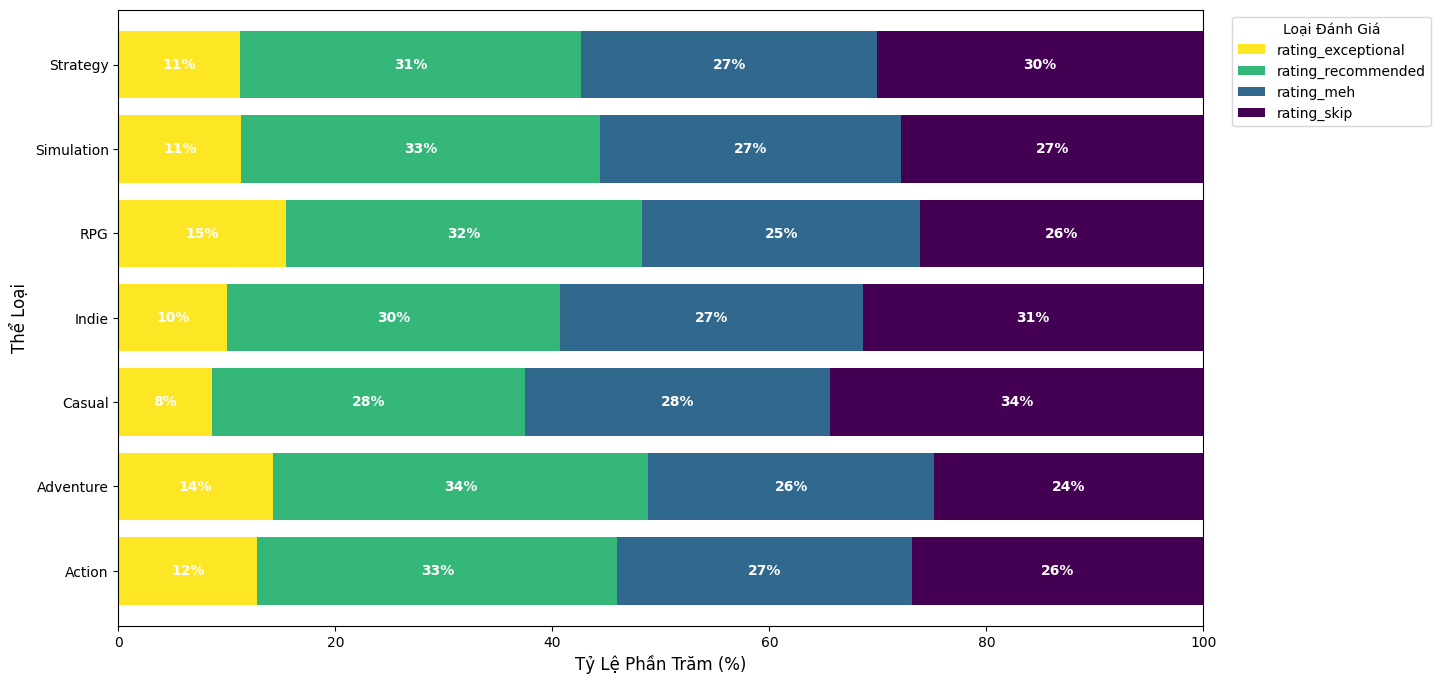

In [11]:
print("\n4.2. Vẽ biểu đồ hồ sơ đánh giá theo thể loại")
if 'df_genres_exploded' in locals():
    top_genres_for_ratings = df_genres_exploded['genres'].value_counts().nlargest(7).index
    genre_rating_profile = df_genres_exploded[df_genres_exploded['genres'].isin(top_genres_for_ratings)]
    genre_rating_profile = genre_rating_profile.groupby('genres')[['rating_exceptional', 'rating_recommended', 'rating_meh', 'rating_skip']].sum()

    genre_rating_profile_percent = genre_rating_profile.div(genre_rating_profile.sum(axis=1), axis=0) * 100

    ax = genre_rating_profile_percent.plot(
        kind='barh', stacked=True, figsize=(14, 8), colormap='viridis_r', width=0.8)

    for container in ax.containers:
        labels = [f'{int(v)}%' if v > 4 else '' for v in container.datavalues]
        ax.bar_label(container, labels=labels, label_type='center', color='white', weight='bold', fontsize=10)


    plt.xlabel('Tỷ Lệ Phần Trăm (%)', fontsize=12)
    plt.ylabel('Thể Loại', fontsize=12)
    plt.legend(title='Loại Đánh Giá', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.xlim(0, 100)
    plt.show()

Biểu đồ này phân tích "hồ sơ đánh giá" của người dùng, cho thấy mỗi thể loại game có một mô hình thành công và rủi ro riêng.

*   RPG (Nhập vai): Có tỷ lệ "Exceptional" (Xuất sắc) cao vượt trội (15%). Điều này cho thấy người chơi của thể loại này có yêu cầu rất cao về chất lượng, và một khi được đáp ứng, họ sẽ đánh giá game là một siêu phẩm.

*   Adventure (Phiêu lưu) và Simulation (Mô phỏng): Hai thể loại này có tỷ lệ "Recommended" (Khuyên chơi) rất cao trong khi tỷ lệ "Skip" (Bỏ qua) lại thuộc hàng thấp nhất. Đây là dấu hiệu của các thể loại "an toàn", mang lại trải nghiệm ổn định và làm hài lòng phần lớn người chơi.

*   Casual (Phổ thông): Ngược lại, thể loại này có tỷ lệ "Exceptional" thấp nhất và tỷ lệ "Skip" cao nhất. Dữ liệu cho thấy game casual dễ tiếp cận nhưng cũng dễ bị người chơi xem là không đủ sâu sắc và bỏ qua.

*   Indie (Độc lập): Đây là trường hợp thú vị nhất, khi tỷ lệ "Recommended" và "Skip" gần như bằng nhau. Điều này phản ánh chính xác bản chất đa dạng và thử nghiệm của game indie: hoặc rất hợp gu, hoặc hoàn toàn không.


=> Kết luận: Dữ liệu cho thấy không có một tiêu chuẩn chất lượng chung cho tất cả. Mỗi thể loại game thu hút một nhóm người chơi khác nhau với những kỳ vọng riêng, và việc phân tích "hồ sơ đánh giá" này giúp xác định đúng thế mạnh và rủi ro của từng thị trường..


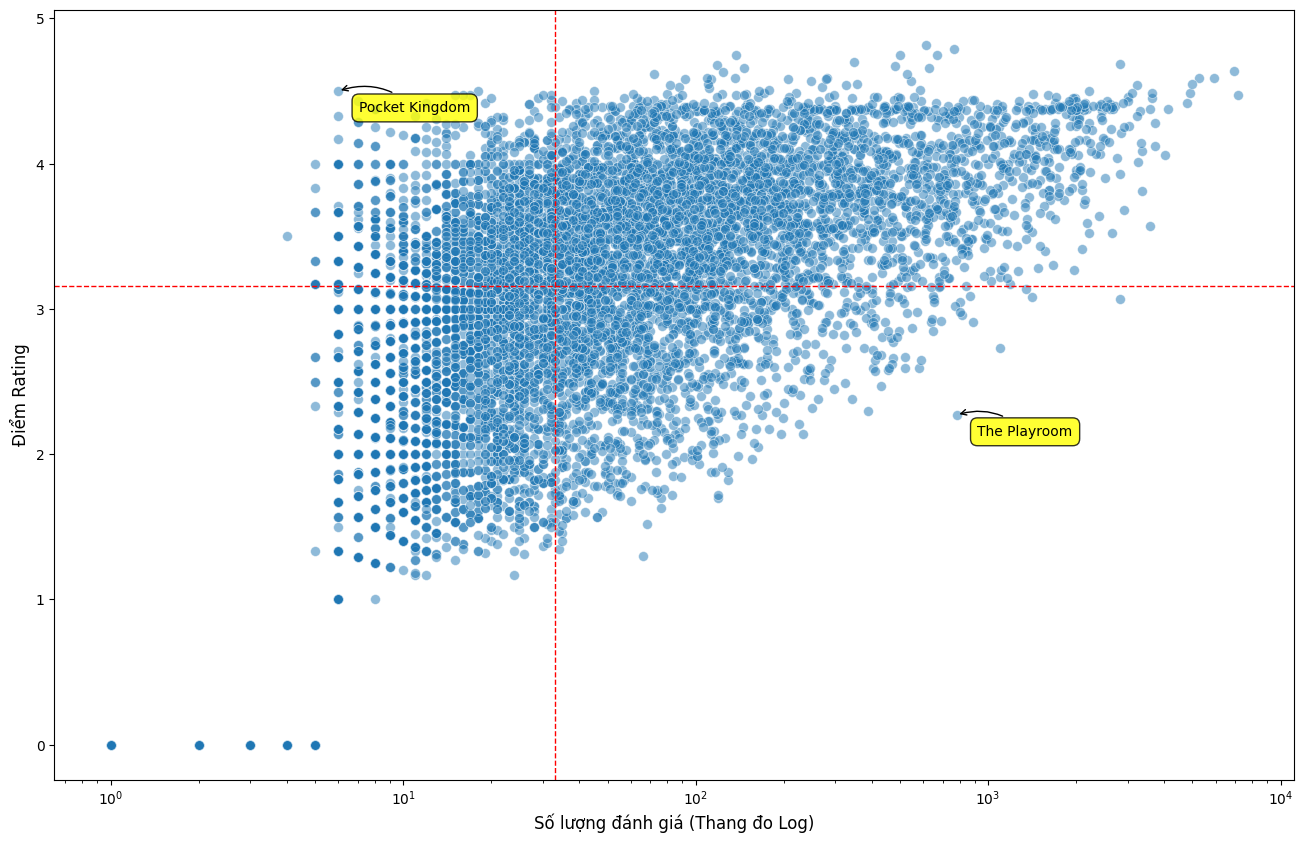

In [12]:


if 'df' in locals() and not df.empty:
    df_plot = df[(df['ratings_count'] > 0) & (df['rating'].notna())].copy()

    if not df_plot.empty:
        # --- Phần 1: Vẽ biểu đồ nền như cũ ---
        median_rating = df_plot['rating'].median()
        median_players = df_plot['ratings_count'].median()

        fig, ax = plt.subplots(figsize=(16, 10))

        sns.scatterplot(
            data=df_plot,
            x='ratings_count',
            y='rating',
            alpha=0.5,
            s=50,
            ax=ax
        )
        ax.set_xscale('log')

        ax.axhline(y=median_rating, color='red', linestyle='--', lw=1)
        ax.axvline(x=median_players, color='red', linestyle='--', lw=1)

        # --- Phần 2: Cải tiến - Tự động tìm và dán nhãn game tiêu biểu ---
        rating_p25 = df_plot['rating'].quantile(0.25)
        rating_p75 = df_plot['rating'].quantile(0.75)
        players_p25 = df_plot['ratings_count'].quantile(0.25)
        players_p75 = df_plot['ratings_count'].quantile(0.75)

        hidden_gems = df_plot[(df_plot['rating'] > rating_p75) & (df_plot['ratings_count'] < players_p25)]
        top_hidden_gem = hidden_gems.nlargest(1, 'rating')

        disappointments = df_plot[(df_plot['rating'] < rating_p25) & (df_plot['ratings_count'] > players_p75)]
        top_disappointment = disappointments.nlargest(1, 'ratings_count')

        examples = pd.concat([top_hidden_gem, top_disappointment])
        for i, row in examples.iterrows():
            ax.annotate(row['name'],
                        xy=(row['ratings_count'], row['rating']),
                        xytext=(15, -15),
                        textcoords='offset points',
                        ha='left',
                        arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.3", color='black'),
                        bbox=dict(boxstyle="round,pad=0.5", fc="yellow", ec="k", lw=1, alpha=0.8))

        # --- Phần 3: Hoàn thiện biểu đồ ---

        ax.set_xlabel('Số lượng đánh giá (Thang đo Log)', fontsize=12)
        ax.set_ylabel('Điểm Rating', fontsize=12)
        plt.show()

    else:
        print("Không có đủ dữ liệu để vẽ biểu đồ.")
else:
    print("DataFrame 'df' chưa được tạo hoặc không có dữ liệu.")

biểu đồ này phân tích thị trường rất hiệu quả. Nó thể hiện rõ mối quan hệ phức tạp giữa chất lượng (Điểm Rating) và mức độ phổ biến (Số lượng đánh giá).

Điểm mạnh nhất của biểu đồ là việc sử dụng thang đo log và chia không gian thành 4 góc phần tư. Phương pháp này giúp bóc tách một đám dữ liệu dày đặc thành các nhóm chiến lược có ý nghĩa:

*   Góc trên bên phải: Bom tấn (Chất lượng cao, Phổ biến cao)

*   Góc trên bên trái: Viên ngọc ẩn (Chất lượng cao, Phổ biến thấp)

*   Góc dưới bên phải: Phổ biến nhưng chất lượng thấp

*   Góc dưới bên trái: Thất bại (Chất lượng thấp, Phổ biến thấp)


=> Kết luận: Sự thành công trong ngành game không phải là một con đường duy nhất, có những game thành công về mặt thương mại và có những game thành công về mặt nghệ thuật.

Ví dụ:

+ "Pocket Kingdom" (Ví dụ về Viên ngọc ẩn):

*   Dữ liệu: Game này có điểm rating rất cao (khoảng 4.2), nhưng số lượng người đánh giá lại cực kỳ thấp (chỉ vài chục).
*   Phân tích: Đây là một ví dụ hoàn hảo cho một game chất lượng cao nhưng chưa được khám phá. Nó có thể là một sản phẩm tâm huyết từ một studio nhỏ hoặc thuộc một thể loại kén người chơi. Mặc dù không tiếp cận được số đông, nhưng những ai đã chơi nó đều dành cho nó sự yêu mến và đánh giá rất tích cực. Đây là một cơ hội marketing bị bỏ lỡ.

+  "The Playroom" (Ví dụ về game Phổ biến nhưng chất lượng thấp):

*   Dữ liệu: Game này có điểm rating thấp (khoảng 2.2) nhưng lại có số lượng người đánh giá rất cao (gần 1,000).

*   Phân tích: Đây là trường hợp một sản phẩm tiếp cận được lượng người dùng khổng lồ không phải vì chất lượng nội tại. Sự phổ biến của nó có thể đến từ việc là game miễn phí đi kèm hoặc được cài đặt sẵn trên hệ máy PlayStation 4. Người dùng thử nó vì rào cản gia nhập bằng không, nhưng trải nghiệm không đủ tốt để họ đưa ra những đánh giá tích cực.



###5. Thời gian chơi và độ phổ biến

5.1. Vẽ biểu đồ rating trung bình theo từng khoảng thời gian chơi


/tmp/ipython-input-13-2806714980.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_rating_per_bin = df_playtime_filtered.groupby('playtime_bin')['rating'].mean().reset_index()


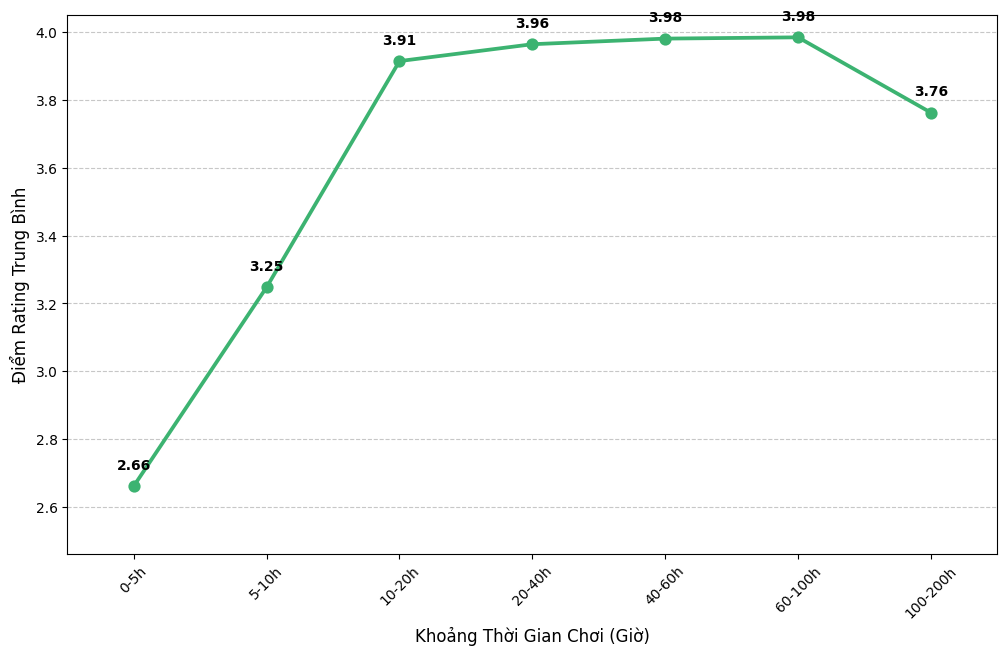

In [13]:
print("5.1. Vẽ biểu đồ rating trung bình theo từng khoảng thời gian chơi")
if not df.empty:
    df_playtime_filtered = df[(df['playtime'] > 0) & (df['playtime'] < 200)].copy()

    bins = [0, 5, 10, 20, 40, 60, 100, 200]
    labels = [f'{bins[i]}-{bins[i+1]}h' for i in range(len(bins)-1)]
    df_playtime_filtered['playtime_bin'] = pd.cut(df_playtime_filtered['playtime'], bins=bins, labels=labels, right=False)

    avg_rating_per_bin = df_playtime_filtered.groupby('playtime_bin')['rating'].mean().reset_index()

    plt.figure(figsize=(12, 7))

    ax = sns.pointplot(data=avg_rating_per_bin, x='playtime_bin', y='rating', color='mediumseagreen', markers='o')

    for i, point in enumerate(avg_rating_per_bin['rating']):
        ax.text(i, point + 0.05, f'{point:.2f}', ha='center', size='medium', color='black', weight='semibold')


    plt.xlabel('Khoảng Thời Gian Chơi (Giờ)', fontsize=12)
    plt.ylabel('Điểm Rating Trung Bình', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(bottom=avg_rating_per_bin['rating'].min() - 0.2)
    plt.show()


Biểu đồ này cho thấy một xu hướng rõ ràng: game có thời gian chơi càng dài thì điểm rating trung bình càng cao.

*   Bước ngoặt lớn nhất xảy ra sau mốc 10 giờ chơi, khi điểm rating tăng vọt. Điều này cho thấy người chơi chỉ sẵn sàng đầu tư thời gian vào những game thực sự chất lượng.

*   Điểm rating đạt đỉnh và ổn định ở mức rất cao đối với các game có thời gian chơi từ 40-100 giờ, đây có thể xem là "vùng đất của siêu phẩm".

*   Có một sự sụt giảm nhẹ ở nhóm game trên 100 giờ, có thể do số lượng ít hoặc các yếu tố gây tranh cãi trong các game cực dài.

=> Kết luận: Thời gian chơi là một chỉ báo mạnh mẽ về chất lượng cảm nhận của một tựa game.


5.2. Vẽ biểu đồ phân phối thời gian chơi


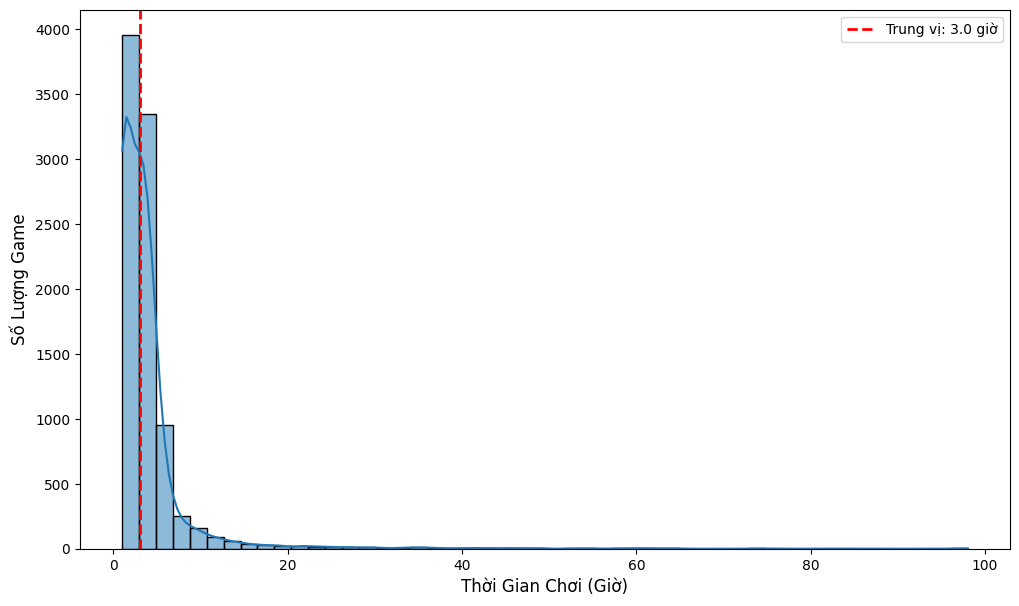

In [14]:
print("\n5.2. Vẽ biểu đồ phân phối thời gian chơi")
if not df.empty:
    plt.figure(figsize=(12, 7))
    data_to_plot = df[(df['playtime'] > 0) & (df['playtime'] <= 100)]['playtime']
    sns.histplot(data_to_plot, bins=50, kde=True)

    median_playtime = data_to_plot.median()
    plt.axvline(median_playtime, color='red', linestyle='--', lw=2, label=f'Trung vị: {median_playtime:.1f} giờ')


    plt.xlabel('Thời Gian Chơi (Giờ)', fontsize=12)
    plt.ylabel('Số Lượng Game', fontsize=12)
    plt.legend()
    plt.show()

Biểu đồ này cho thấy phần lớn các game trong bộ dữ liệu có thời gian chơi rất ngắn.

*   Tập trung ở mức thấp: Số lượng game giảm mạnh khi thời gian chơi tăng lên. Phần lớn game tập trung ở khoảng dưới 10 giờ.

*   Giá trị trung vị: Một game "điển hình" trong bộ dữ liệu này chỉ yêu cầu khoảng 3 giờ để hoàn thành, được thể hiện qua đường trung vị.

*   Phân phối lệch phải: Hình dạng của biểu đồ bị lệch hẳn về bên phải, cho thấy sự tồn tại của một số ít game có thời gian chơi rất dài, nhưng chúng không phải là đại diện cho số đông.

=> Kết luận: Thị trường game bị chi phối bởi các game có thời gian chơi ngắn, phù hợp với xu hướng chơi game nhanh và tiện lợi.





###6. Tags


📊 7.1. Vẽ biểu đồ Top 20 tags phổ biến nhất


/tmp/ipython-input-15-4039288541.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_20_tags.values, y=top_20_tags.index, palette='crest')


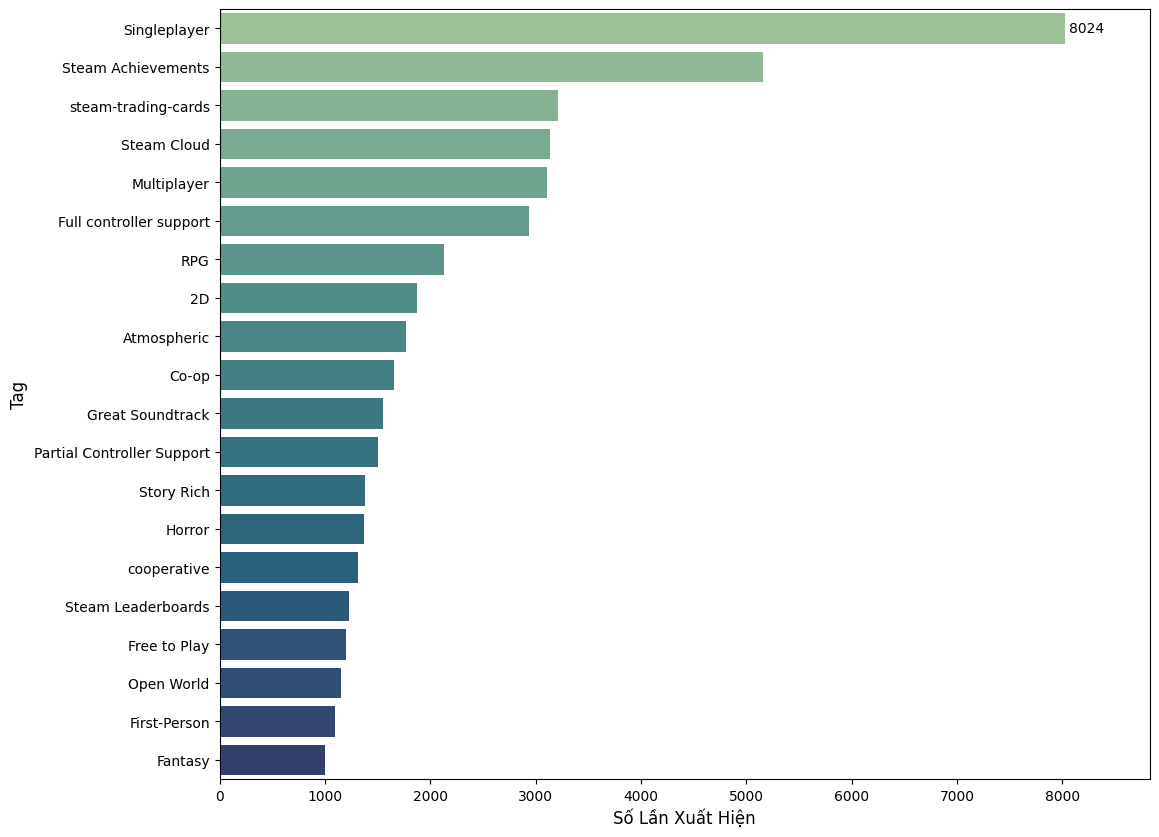

In [15]:
print("📊 7.1. Vẽ biểu đồ Top 20 tags phổ biến nhất")
if 'df_tags_exploded' in locals():
    plt.figure(figsize=(12, 10))
    top_20_tags = df_tags_exploded['tags'].value_counts().nlargest(20)

    ax = sns.barplot(x=top_20_tags.values, y=top_20_tags.index, palette='crest')
    ax.bar_label(ax.containers[0], padding=3, fontsize=10)

    plt.xlabel('Số Lần Xuất Hiện', fontsize=12)
    plt.ylabel('Tag', fontsize=12)
    plt.xlim(0, top_20_tags.values.max() * 1.1)
    plt.show()

Biểu đồ này phân tích các 'tag' được sử dụng nhiều nhất, cho thấy những đặc điểm và tính năng nào là phổ biến và được quan tâm nhất trong thế giới game.

*   Sự thống trị của trải nghiệm chơi đơn: Tag Singleplayer chiếm vị trí áp đảo với hơn 8000 lượt, cho thấy phần lớn các game trong bộ dữ liệu này tập trung vào trải nghiệm chơi một mình. Đây là đặc tính phổ biến nhất, vượt xa tất cả các tag còn lại.

*   Sự ảnh hưởng của hệ sinh thái Steam: Một loạt các tag hàng đầu đều liên quan trực tiếp đến nền tảng Steam (Steam Achievements, steam-trading-cards, Steam Cloud, Steam Leaderboards). Điều này cho thấy hai khả năng: Tập dữ liệu này có nguồn gốc chủ yếu từ Steam, hoặc Các tính năng của Steam đã trở thành một phần không thể thiếu trong các game PC hiện đại.

*   Các tính năng và trải nghiệm được ưa chuộng: Bên cạnh chơi đơn, các tag như Multiplayer, Full controller support, Co-op và Story Rich cũng rất phổ biến. Điều này cho thấy người chơi đánh giá cao cả trải nghiệm chơi cùng bạn bè, sự tiện lợi khi dùng tay cầm và những câu chuyện hấp dẫn.

=> Kết luận: Trải nghiệm chơi đơn là cốt lõi của phần lớn các game. Tuy nhiên, các tính năng gắn liền với nền tảng Steam và các yếu tố về trải nghiệm người dùng như hỗ trợ tay cầm, chơi mạng và cốt truyện sâu sắc cũng là những đặc điểm cực kỳ phổ biến và quan trọng, định hình nên một tựa game hiện đại.





7.2. Tạo Word Cloud từ các tags


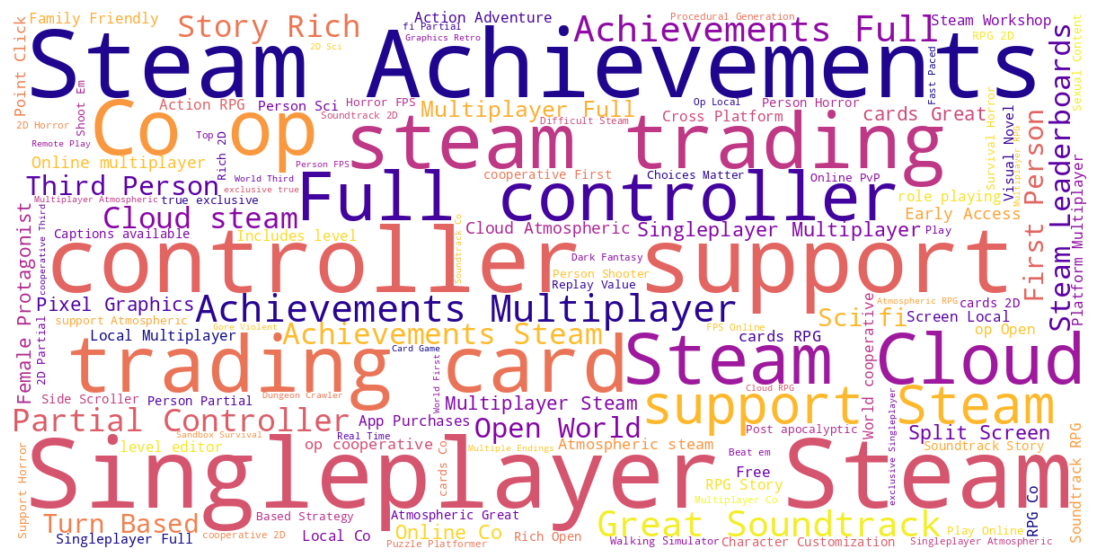

In [16]:
print("\n7.2. Tạo Word Cloud từ các tags")
if 'df_tags_exploded' in locals() and not df_tags_exploded.empty:
    text = " ".join(tag for tag in df_tags_exploded['tags'])
    wordcloud = WordCloud(
        width=1200, height=600, background_color='white',
        colormap='plasma', min_font_size=10, random_state=42 # Thêm random_state để kết quả nhất quán
    ).generate(text)
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()


WordCloud này trực quan hóa "ADN" của các game trong bộ dữ liệu, với kích thước của từ tương ứng với tần suất xuất hiện.

*   "Bộ ba" thống trị: Các game chủ yếu là Singleplayer, tích hợp sâu với hệ sinh thái Steam và có controller support đầy đủ.

*   Các đặc điểm cốt lõi khác: Các yếu tố như Multiplayer, Co-op, Story Rich và Atmospheric cũng rất phổ biến, cho thấy đây là những yếu tố quan trọng tạo nên một game thành công.

=> Kết luận: Một game điển hình trong bộ dữ liệu này là một trải nghiệm chơi đơn, thân thiện với người dùng, được xây dựng trên nền tảng Steam và thường được làm phong phú hơn bởi các yếu tố chơi mạng và cốt truyện hấp dẫn.


###8. Theo thời gian (Time series)

 8.1 & 8.2. Vẽ biểu đồ kép về Số lượng game và Rating trung bình theo năm 


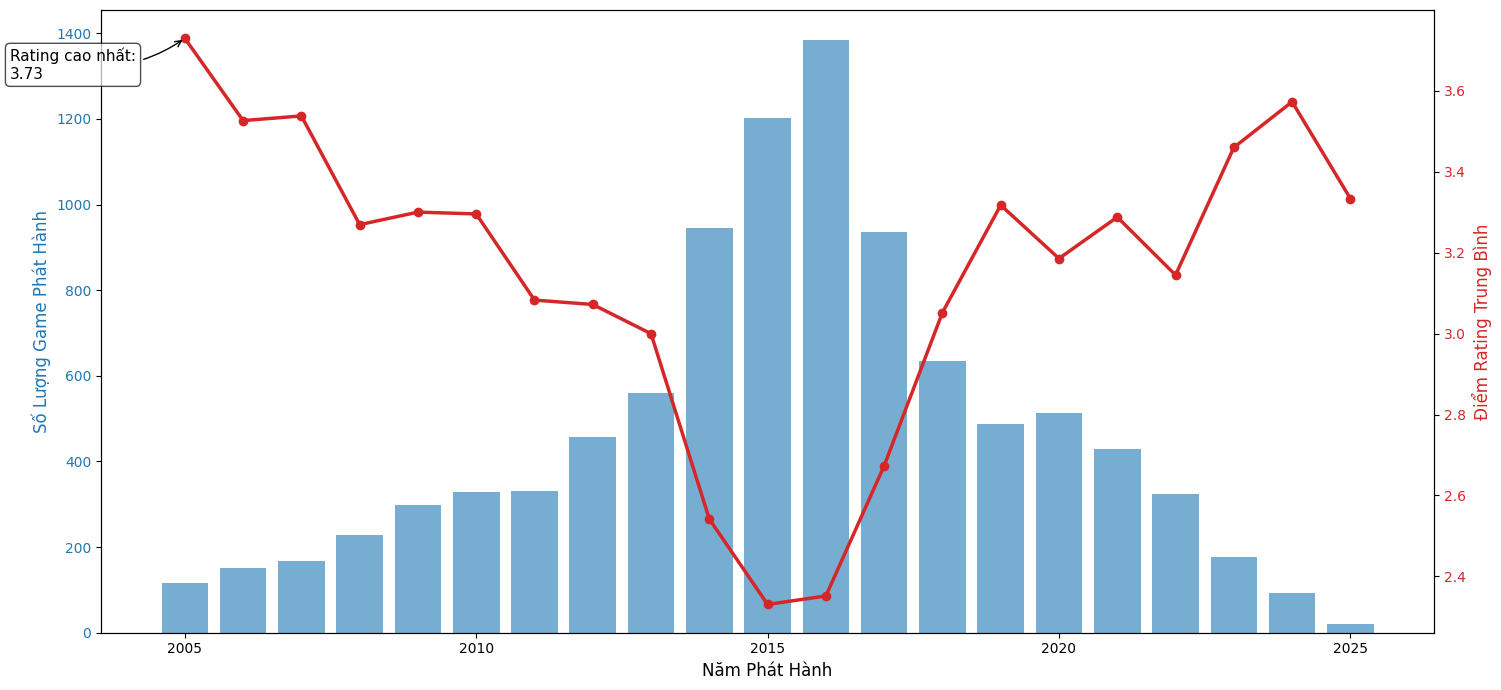

In [17]:
print(" 8.1 & 8.2. Vẽ biểu đồ kép về Số lượng game và Rating trung bình theo năm ")
if not df.empty:
    rating_by_year = df.groupby('release_year')['rating'].agg(['mean', 'count']).reset_index()
    reliable_years = rating_by_year[rating_by_year['count'] > 10]
    reliable_years = reliable_years[reliable_years['release_year'] >= 2000]

    fig, ax1 = plt.subplots(figsize=(15, 7))

    color = 'tab:blue'
    ax1.set_xlabel('Năm Phát Hành', fontsize=12)
    ax1.set_ylabel('Số Lượng Game Phát Hành', color=color, fontsize=12)
    ax1.bar(reliable_years['release_year'], reliable_years['count'], color=color, alpha=0.6, label='Số lượng game')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Điểm Rating Trung Bình', color=color, fontsize=12)
    ax2.plot(reliable_years['release_year'], reliable_years['mean'], color=color, marker='o', lw=2.5, label='Rating trung bình')
    ax2.tick_params(axis='y', labelcolor=color)

    peak_rating_year = reliable_years.loc[reliable_years['mean'].idxmax()]
    ax2.annotate(f'Rating cao nhất:\n{peak_rating_year["mean"]:.2f}',
                 xy=(peak_rating_year['release_year'], peak_rating_year['mean']),
                 xytext=(peak_rating_year['release_year'] - 3, peak_rating_year['mean'] - 0.1),
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"),
                 fontsize=11, bbox=dict(boxstyle="round", fc="w", alpha=0.7))


    fig.tight_layout()
    plt.show()


Biểu đồ này cho thấy một mối quan hệ nghịch đảo rất thú vị giữa số lượng game được phát hành và chất lượng trung bình của chúng.

*   "Càng nhiều càng loãng": Giai đoạn bùng nổ về số lượng game (2015-2017), cũng chính là giai đoạn mà điểm rating trung bình của các game chạm đáy. Điều này cho thấy sự gia tăng đột biến về số lượng, có thể do làn sóng game indie, đã mang theo rất nhiều tựa game chất lượng thấp, kéo chất lượng chung của thị trường đi xuống.

*   "Ít mà chất": Ngược lại, trong những năm có số lượng game phát hành ít hơn (trước 2012 và sau 2020), điểm rating trung bình lại có xu hướng cao hơn. Điều này cho thấy một thị trường ít bão hòa hơn có thể có chất lượng trung bình cao hơn.  

=> Kết luận: Biểu đồ này chỉ ra rằng sự bùng nổ về số lượng không đồng nghĩa với sự gia tăng về chất lượng. Giai đoạn đỉnh cao về sản lượng game lại là giai đoạn có chất lượng trung bình thấp nhất, cho thấy tác động của việc thị trường bị "pha loãng" bởi các game chất lượng thấp.




8.3. Vẽ biểu đồ thể loại thịnh hành theo năm 


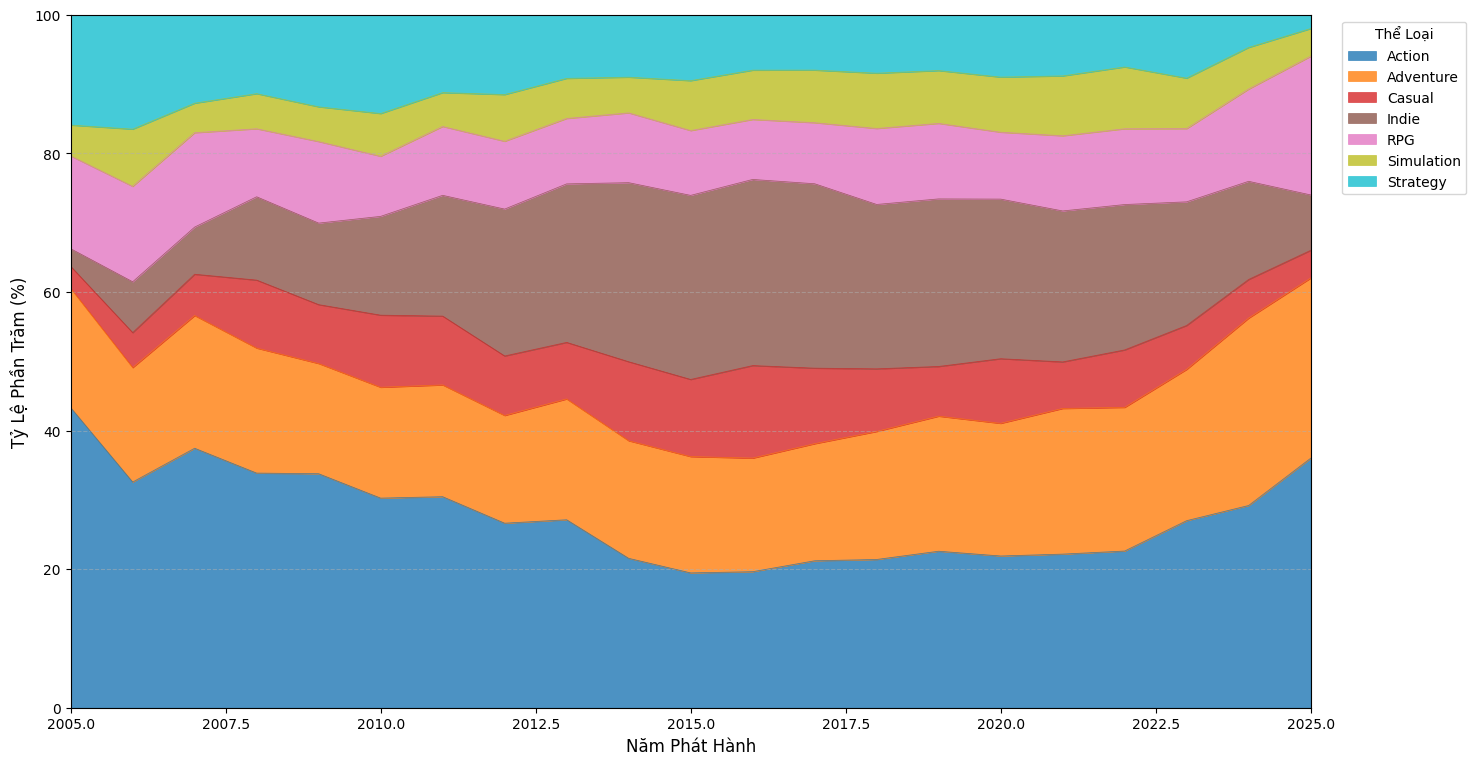

In [18]:
# --- 8.3. Thể loại thịnh hành theo năm ---
print("\n8.3. Vẽ biểu đồ thể loại thịnh hành theo năm ")
if 'df_genres_exploded' in locals():
    top_genres_list = df_genres_exploded['genres'].value_counts().nlargest(7).index
    df_top_genres_time = df_genres_exploded[df_genres_exploded['genres'].isin(top_genres_list)]

    genre_trends = df_top_genres_time.groupby(['release_year', 'genres']).size().unstack(fill_value=0)
    genre_trends_percent = genre_trends.apply(lambda x: 100 * x / x.sum(), axis=1)
    genre_trends_percent = genre_trends_percent.loc[2000:]

    ax = genre_trends_percent.plot(
        kind='area', stacked=True, figsize=(16, 9), colormap='tab10',
        linewidth=0.5, alpha=0.8)


    plt.ylabel('Tỷ Lệ Phần Trăm (%)', fontsize=12)
    plt.xlabel('Năm Phát Hành', fontsize=12)
    plt.legend(title='Thể Loại', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.ylim(0, 100)
    plt.margins(x=0, y=0)
    plt.grid(axis='y', linestyle='--', alpha = 0.5)
    plt.show()

Biểu đồ này cho thấy sự thay đổi về mức độ phổ biến tương đối (thị phần) của các thể loại game hàng đầu từ năm 2000 đến nay.

*   Sự ổn định của các "ông lớn": Thể loại Action (màu xanh dương) luôn là thể loại chiếm thị phần lớn nhất và ổn định nhất, khẳng định vị thế trụ cột của mình qua hai thập kỷ. Indie và RPG cũng duy trì một thị phần đáng kể và tương đối ổn định.

*   Sự trỗi dậy của Adventure: Xu hướng đáng chú ý nhất là sự tăng trưởng mạnh mẽ của thể loại Adventure (màu cam), đặc biệt từ khoảng năm 2015 trở đi. Thị phần của thể loại này ngày càng mở rộng, cho thấy sự thay đổi trong thị hiếu người chơi, hướng tới các game có yếu tố khám phá và cốt truyện sâu sắc hơn.

=> Kết luận: Trong khi Action vẫn là "vua" về thị phần, sự trỗi dậy của Adventure là xu hướng nổi bật nhất, cho thấy thị trường đang ngày càng ưa chuộng các trải nghiệm có chiều sâu về cốt truyện và khám phá.
